In [13]:
from bs4 import BeautifulSoup
import nltk
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# parse sample file
datapath ='../'
soup = BeautifulSoup(open(datapath+ 'example_ttml.xml'), 'html.parser')
result = [(p['begin'], p['end'], p.text) for p in soup.find_all('p')]

In [5]:
#text block
raw= ' '.join([x[2] for x in result])

In [17]:
text = nltk.word_tokenize(raw)
df = pd.DataFrame(nltk.pos_tag(text),columns =['word','type'])
df['type'].value_counts()

NN      46
IN      20
DT      18
PRP     16
VB      15
JJ      13
VBP     11
TO      10
CC       9
NNS      8
RB       6
VBG      5
VBD      5
MD       4
PRP$     3
VBN      3
POS      2
VBZ      2
JJR      1
EX       1
WDT      1
RBR      1
Name: type, dtype: int64

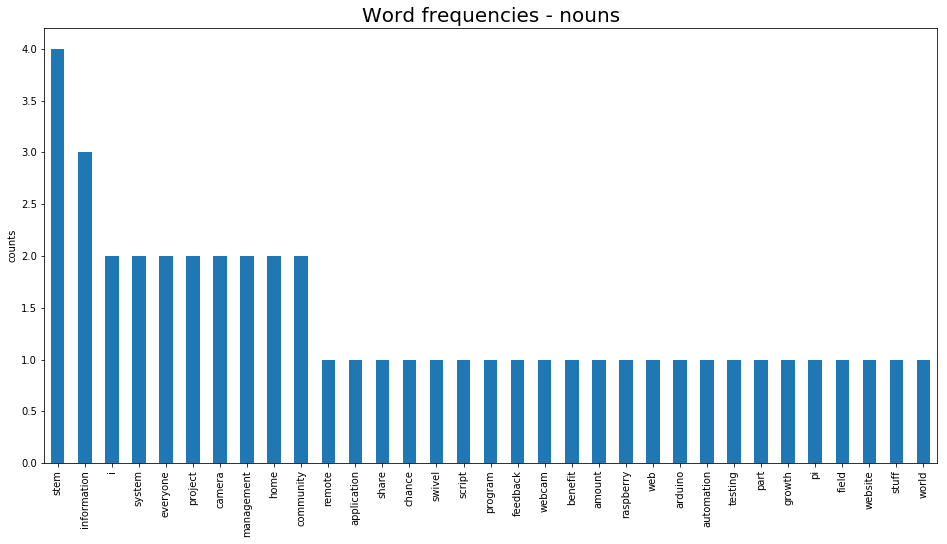

In [45]:
ax=df[df['type']=='NN']['word'].value_counts().plot.bar(figsize=(16,8))
ax.set_ylabel('counts')
ax.set_title('Word frequencies - nouns', fontsize=20)